In [1]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

from pprint import pprint
import numpy as np
import torchinfo
from matplotlib import pyplot as plt
import time
import cv2
from PIL import Image
import time
from tqdm import tqdm
import torchinfo 
from pprint import pprint

# this is same for all the code

# Dataset class implementation was done by Anshul EE20BTECH1104
# Residual block was written by Dhruv Srikanth EE20BTECH11014
# various functions like mse, mae, ssim were written by Dhruv Srikanth and Anshul Gupta
# Basic architecture of the model was taken from internet and then later modified by Utkarsh Doshi E20BTECH11052

https://github.com/AntixK/PyTorch-VAE/blob/master/models/vq_vae.py

In [2]:
channels_img = 3
batch_size = 64
data_dir = r'C:/Users/utkar/Desktop/ivp/FFHQ64x64/'
#data_dir_new = r'C:/Users/utkar/Desktop/ML/Dataset/Celeb_dataset/500_img'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((64, 64)),
    #transforms.Normalize(())
    ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

device = 'cuda' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!nvidia-smi

Tue Apr 25 01:53:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.52       Driver Version: 528.52       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    13W /  80W |   1785MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# here we thought of constructing the high level and low level featrures separately by trying to construct the difference of the low level features and high level features
# Idea came to Utkarsh but Anshul and Dhruv build over it about how we might do that

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


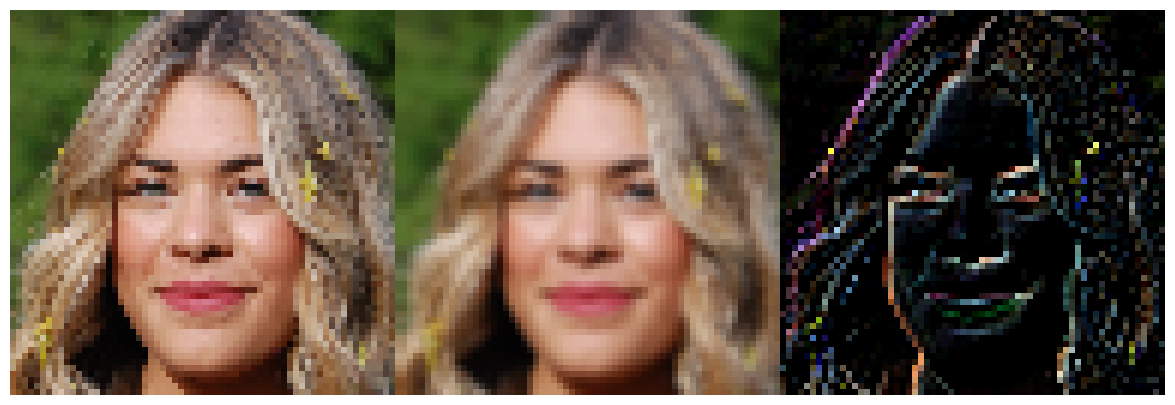

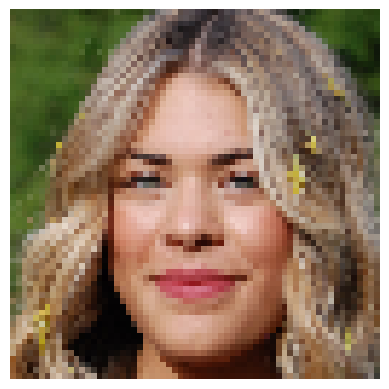

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


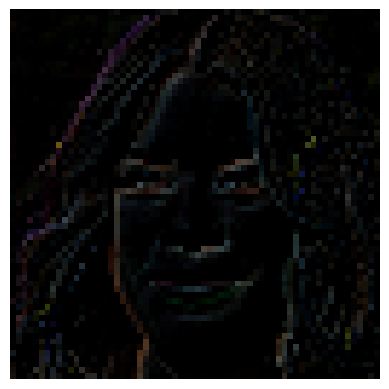

In [5]:
img = dataset[10500][0].permute(1, 2, 0)
#plt.axis('off')
#plt.imshow(img)
#plt.show()

img_blur = torch.tensor(cv2.blur(np.array(img), (2, 2)))
#plt.axis('off')
#plt.imshow(img_blur)
#plt.show()

img_d = img - img_blur
imgs = np.concatenate((img, img_blur, img_d*3), 1)
plt.figure(figsize=(15, 5))
plt.axis('off')
plt.imshow(imgs)
plt.show()

plt.axis('off')
plt.imshow(img_d + img_blur)
plt.show()

plt.axis('off')
plt.imshow(img_d)
plt.show()

# It was an iterative procss here we had a meeting and then we thought of adding this so we all three have equal contribution

# copied and then modified to suit our purpose
https://github.com/LeeJunHyun/Image_Segmentation

In [6]:


class AttentionBlock(nn.Module):
    def __init__(self, in_channels, kernel_size=1):
        super(AttentionBlock, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=kernel_size)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=kernel_size)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Project features onto query, key, and value
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        
        # Compute attention map
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        
        # Apply attention to value
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        
        # Apply gamma scaling and add residual connection
        out = self.gamma * out + x
        
        return out


In [7]:
# residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResidualBlock, self).__init__()
        self.ResBlock = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=2, bias=False, dilation=2),
            nn.ReLU(True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        return x + self.ResBlock(x)
    

In [8]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta
        
        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)  # weight initializing
        
    def forward(self, latents):
        latents = latents.permute(0, 2, 3, 1).contiguous()  # taking dimension (channel) to right end
        latents_shape = latents.shape
        flat_latents = latents.view(-1, self.D)
        
        # computing L2 distance
        dist = torch.sum(flat_latents ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight ** 2, dim=1) - \
               2 * torch.matmul(flat_latents, self.embedding.weight.t())  # [BHW x K]
            
        # Get the encoding that has the min distance
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)  # [BHW, 1]
        
        # Convert to one-hot encodings
        device = latents.device
        encoding_one_hot = torch.zeros(encoding_inds.size(0), self.K, device=device)
        encoding_one_hot.scatter_(1, encoding_inds, 1)  # [BHW x K]

        # Quantize the latents
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)  # [BHW, D]
        quantized_latents = quantized_latents.view(latents_shape)  # [B x H x W x D]
        
        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())
        
        vq_loss = commitment_loss * self.beta + embedding_loss

        # Add the residue back to the latents
        quantized_latents = latents + (quantized_latents - latents).detach()

        return quantized_latents.permute(0, 3, 1, 2).contiguous(), vq_loss  # [B x D x H x W]

In [9]:
# VQ-VAE
class VQVAE(nn.Module):
    def __init__(self,
                 in_c,
                 embedding_dim,
                 num_embeddings,
                 hidden_dims=None,
                 beta=0.25,
                 img_size=64,
                 ):
        super(VQVAE, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_embedding = num_embeddings
        self.img_size = img_size
        self.beta = beta
        
        modules = []
        if hidden_dims is None:
            hidden_dims = [128, 256]
        
        for h_dim in hidden_dims:
            modules.append(nn.Sequential(
                nn.Conv2d(in_c, out_channels=h_dim, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(True),
            ))
            in_c = h_dim
            
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            )
        )
        
        for _ in range(6):
            modules.append(
                ResidualBlock(in_c, in_c)
            )   # see for relu
            modules.append(AttentionBlock(in_c))
            
            
        modules.append(nn.LeakyReLU())
        
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_c, embedding_dim, kernel_size=1, stride=1),
                nn.LeakyReLU()
            )
        )
        
        self.encoder = nn.Sequential(*modules)
        
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, self.beta)
        
        # Build Decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(embedding_dim, hidden_dims[-1], kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            )
        )
        
        
        for _ in range(6):
            modules.append(
                ResidualBlock(hidden_dims[-1], hidden_dims[-1])
            )
            modules.append(AttentionBlock(hidden_dims[-1]))
            
        modules.append(nn.LeakyReLU())
        hidden_dims.reverse()
        
        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU()
                )
            )
            
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1], out_channels=3, kernel_size=4, stride=2, padding=1),
                nn.Tanh()
            )
        )
        
        self.decoder = nn.Sequential(*modules)
         
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, z):
        z = self.decoder(z)
        return z
    
    def forward(self, x):
        encodings = self.encoder(x)
        quantized_vec, vq_loss = self.vq_layer(encodings)
        return [self.decoder(quantized_vec), x, vq_loss]
    
    def loss_f(self, *args, **kwargs):
        recons = args[0]
        inputs = args[1]
        vq_loss = args[2]
        
        recons_loss = F.mse_loss(recons, inputs)
        
        loss = recons_loss + vq_loss
        return loss, recons_loss, vq_loss
    
    def sample(self, num_samples, current_device):
        raise Warning('VQVAE sampler is not implemented.')

    def generate(self, x):
        return self.forward(x)[0]


In [10]:
# in_c, embedding_dim, num_embeddings, hidden_dims, beta=0.25, img_size=64,
vqvae = VQVAE(3, 128, 128).to(device)
vqvae = torch.load('C:/Users/utkar/Desktop/ivp/models tried/day-7/vqvae_day7_epoch100.pt')

In [11]:
# x = torch.rand((1, 3, 128, 128)).to('cuda')
# print(x.shape)
# encode_vec = vqvae.encoder(x)
# vqvae.vq_layer(encode_vec)[0].shape

In [12]:
pprint(torchinfo.summary(vqvae, (64, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [64, 3, 64, 64]           --
├─Sequential: 1-1                        [64, 128, 16, 16]         --
│    └─Sequential: 2-1                   [64, 128, 32, 32]         --
│    │    └─Conv2d: 3-1                  [64, 128, 32, 32]         6,272
│    │    └─LeakyReLU: 3-2               [64, 128, 32, 32]         --
│    └─Sequential: 2-2                   [64, 256, 16, 16]         --
│    │    └─Conv2d: 3-3                  [64, 256, 16, 16]         524,544
│    │    └─LeakyReLU: 3-4               [64, 256, 16, 16]         --
│    └─Sequential: 2-3                   [64, 256, 16, 16]         --
│    │    └─Conv2d: 3-5                  [64, 256, 16, 16]         590,080
│    │    └─LeakyReLU: 3-6               [64, 256, 16, 16]         --
│    └─ResidualBlock: 2-4                [64, 256, 16, 16]         --
│    │    └─Sequential: 3-7              [64, 256, 16, 16]         1,769

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45275


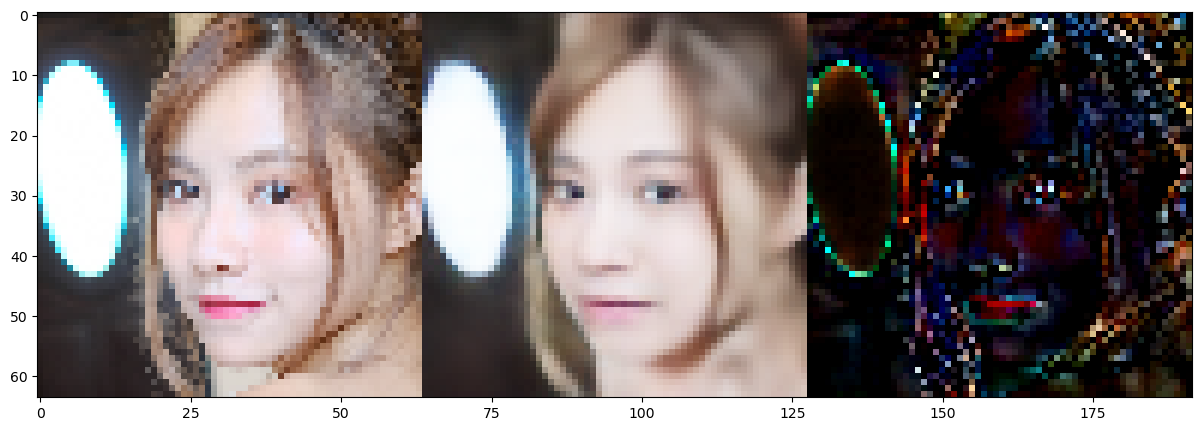

In [47]:
# done by anshul

num_training_updates = 15000

# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2
# 
# embedding_dim = 64
# num_embeddings = 512
# commitment_cost = 0.25
decay = 0.99

vqvae.eval()

learning_rate = 1e-4
optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

def display_func():
    with torch.no_grad():
        n = np.random.randint(0, 50000)
        print(n)
        img = torch.unsqueeze(train_loader.dataset[n][0], 0).to('cuda')
        out = vqvae(img)[0]
        img_d = img - out
        pic = np.transpose(np.concatenate((img.cpu(), out.cpu(), img_d.cpu()*4), 3)[0], (1, 2, 0))
        plt.figure(figsize=(15, 5))
        plt.imshow(pic)
        plt.show()
        
display_func()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


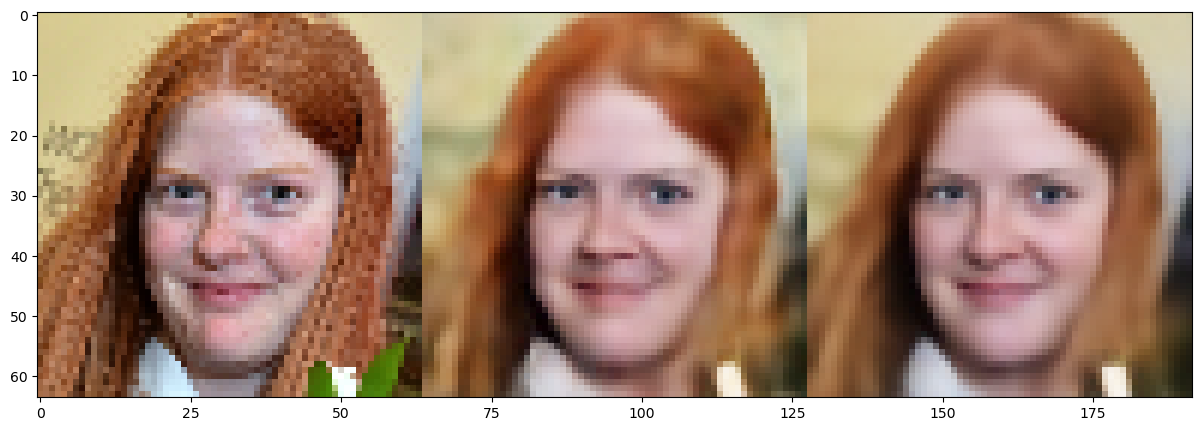

In [93]:
# done by dhruv

with torch.no_grad():
    vqvae.eval()
    n1 = 45275
    img = torch.unsqueeze(train_loader.dataset[n1][0], 0).to('cuda')
    out1 = vqvae.encoder(img)
    qv1, _ = vqvae.vq_layer(out1)
    # pic = np.transpose(np.concatenate((img.cpu(), out1.cpu()), 3)[0], (1, 2, 0))
    # plt.figure(figsize=(10, 5))
    # plt.imshow(pic)
    # plt.show()
    
    n2 = 14482
    img = torch.unsqueeze(train_loader.dataset[n2][0], 0).to('cuda')
    out2 = vqvae.encoder(img)
    qv2, _ = vqvae.vq_layer(out2)
    qv2_gauss = qv2 + torch.normal(0, 1, qv2.shape).cuda()*0.5
    img_recons = vqvae.decoder(qv2)
    img_gauss = vqvae.decoder(qv2_gauss)
    pic = np.transpose(np.concatenate((img.cpu(), img_gauss.cpu(), img_recons.cpu()), 3)[0], (1, 2, 0))
    plt.figure(figsize=(15, 5))
    plt.imshow(pic)
    plt.show()
    x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    # for alpha in x:
    #     qv_c = alpha*qv1 + (1-alpha)*qv2
    #     qv_c1, _ = vqvae.vq_layer(qv_c)
    #     img_mapped = vqvae.decoder(qv_c1)
    #     img_unmapped = vqvae.decoder(qv_c)
    #     pic = np.transpose(np.concatenate((img_mapped.cpu(), img_unmapped.cpu()), 3)[0], (1, 2, 0))
    #     # print(pic.shape)
    #     plt.imshow(pic)  # np.transpose(pic[0], (1, 2, 0))
    #     plt.show()

In [ ]:
from tqdm import tqdm

def train_vqvae(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    
    train_loss = []
    recon_loss = []
    vq_loss = []
    
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_recon_loss = 0
        epoch_vq_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)

            optimizer.zero_grad()

            outputs = model(data)
            loss, recon_loss_batch, vq_loss_batch = model.loss_f(*outputs)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_recon_loss += recon_loss_batch.item()
            epoch_vq_loss += vq_loss_batch.item()

            progress_bar.set_postfix({
                "Train Loss": epoch_train_loss / (batch_idx + 1),
                "Recon Loss": epoch_recon_loss / (batch_idx + 1),
                "VQ Loss": epoch_vq_loss / (batch_idx + 1),
            })
            
        train_loss.append(epoch_train_loss / len(train_loader))
        recon_loss.append(epoch_recon_loss / len(train_loader))
        vq_loss.append(epoch_vq_loss / len(train_loader))
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Recon Loss: {recon_loss[-1]:.4f}, VQ Loss: {vq_loss[-1]:.4f}")
        display_func()
        if epoch % 5 == 0:
            PATH = r'C:/Users/utkar/Desktop/ivp/models tried/day-6/vqvae_day6_epoch' + str(epoch) + '.pt'
            torch.save(vqvae, PATH)
    return train_loss, recon_loss, vq_loss


In [ ]:
train_vqvae(vqvae, train_loader, optimizer, criterion, device, epochs=40)

In [ ]:
# PATH = r'C:/Users/utkar/Desktop/ivp/models tried/day-3/vqvae_without_hlf_day3.pt'
# torch.save(vqvae, PATH)

In [ ]:
display_func()

In [ ]:
def display_func():
    with torch.no_grad():
        n = np.random.randint(0, 50000)
        print(n)
        img = torch.unsqueeze(train_loader.dataset[n][0], 0).to('cuda')
        out = vqvae(img)[0]
        pic = np.transpose(np.concatenate((img.cpu(), out.cpu()), 3)[0], (1, 2, 0))
        plt.imshow(pic)
        plt.show()

In [63]:
codebook_embeddings = vqvae.vq_layer.embedding
codebook_embeddings.weight.shape

torch.Size([512, 128])

In [64]:
codebook_embeddings.weight

Parameter containing:
tensor([[ 3.7896e-01,  3.4291e-01,  2.6806e-01,  ...,  2.9421e-01,
          5.3575e-01,  1.6546e+00],
        [ 4.2072e-02, -3.7458e-03,  2.5372e-03,  ...,  5.1145e-02,
          4.2213e-02,  1.0091e-01],
        [-7.5666e-04, -5.3926e-04, -8.6066e-04,  ...,  1.8527e-03,
          7.5998e-04,  1.7328e-03],
        ...,
        [-3.4498e-04, -1.6371e-03,  7.7143e-04,  ...,  1.6145e-03,
         -1.0334e-03, -2.5089e-04],
        [-8.5900e-04, -3.6633e-04,  1.3106e-03,  ..., -1.0423e-03,
         -1.2283e-03, -1.0417e-03],
        [ 1.1339e-03, -6.4397e-05, -1.8195e-03,  ..., -9.2437e-04,
         -1.7917e-04,  1.8175e-03]], device='cuda:0', requires_grad=True)

In [65]:
dir(vqvae.vq_layer.embedding.state_dict)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [66]:
codebook_embeddings.weight

Parameter containing:
tensor([[ 3.7896e-01,  3.4291e-01,  2.6806e-01,  ...,  2.9421e-01,
          5.3575e-01,  1.6546e+00],
        [ 4.2072e-02, -3.7458e-03,  2.5372e-03,  ...,  5.1145e-02,
          4.2213e-02,  1.0091e-01],
        [-7.5666e-04, -5.3926e-04, -8.6066e-04,  ...,  1.8527e-03,
          7.5998e-04,  1.7328e-03],
        ...,
        [-3.4498e-04, -1.6371e-03,  7.7143e-04,  ...,  1.6145e-03,
         -1.0334e-03, -2.5089e-04],
        [-8.5900e-04, -3.6633e-04,  1.3106e-03,  ..., -1.0423e-03,
         -1.2283e-03, -1.0417e-03],
        [ 1.1339e-03, -6.4397e-05, -1.8195e-03,  ..., -9.2437e-04,
         -1.7917e-04,  1.8175e-03]], device='cuda:0', requires_grad=True)

# idea for clustering code book vectors was given by Utkarsh Doshi and coded by Anshul Gupta and Dhruv srikanth

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html took help from here

C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

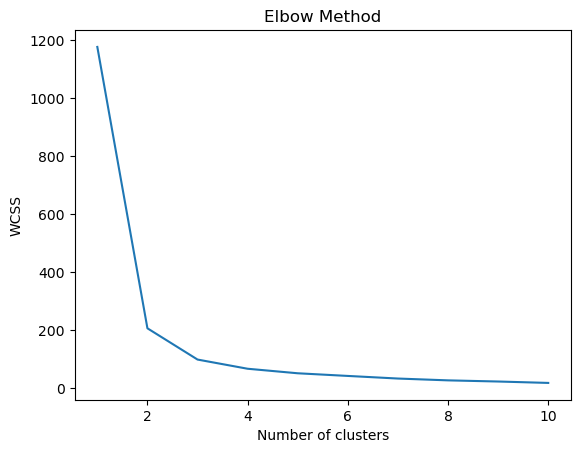

C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

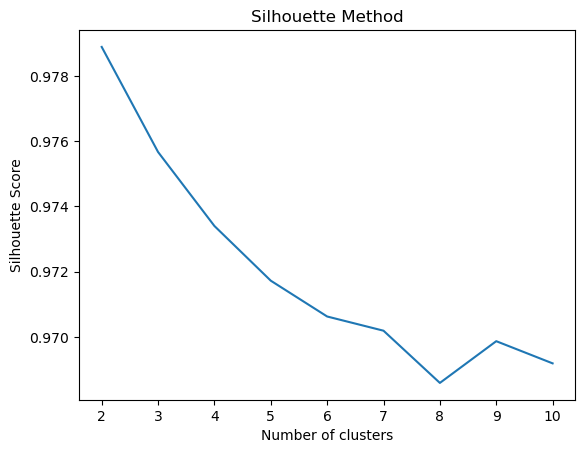

In [67]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

vqvae.eval()
with torch.no_grad():
    data = codebook_embeddings.weight.cpu()
    
    # Find the optimal number of clusters using the elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(1, 11), wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    # Identify the optimal number of clusters using the silhouette score
    silhouette_scores = []
    for n_clusters in range(2, 11):
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    # Plot the silhouette scores for each number of clusters
    plt.plot(range(2, 11), silhouette_scores)
    plt.show()
    
    
    

### https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


In [68]:
# Choose the optimal number of clusters based on the elbow method or the silhouette score
n_clusters = 9


# Cluster the data using the k-means algorithm
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(data)

# Print the cluster labels for each data point
print(pred_y)

C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 4 0 1 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 6 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 